Install KerasCV and update Tensorflow

In [1]:
#%pip install -q --upgrade keras-cv
#%pip install -q --upgrade keras
#%pip install -q --upgrade tensorflow

In [35]:
#%pip install -q silence_tensorflow

In [36]:
# A libraries to avoid keras and tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# A libraries to avoid other warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import math
import keras
import keras_cv
from keras_cv import visualization
import keras
import cv2
import tensorflow
import os
import glob
import json
from collections import defaultdict
import tensorflow as tf
from keras import optimizers

C:\Users\Ronan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Version of keras

In [3]:
print(keras. __version__)

3.4.1


Version of KerasCV

In [4]:
print(keras_cv. __version__)

0.9.0


Version of Tensorflow

In [5]:
print(tf. __version__)

2.16.1


Create dictionnaries to store the IDs of the classes and their actual names

In [6]:
table = {}
class_mapping = {}
counter = 0

In [7]:
def lookup_table(label):
    global counter
    if label in table:
        return table[label]
    counter += 1
    table[label] = counter
    class_mapping[counter] = label
    return table[label]

Data structure

In [8]:
splits = {
    'train': 'data/train',
    'test': 'data/test',
    'validation': 'data/valid'
}

In [9]:
def load_image(filepath):
  # Read the image file from a folder
  image_data = tf.io.read_file(filepath)
  # Decode the image data into a tensor
  return tf.cast(tf.io.decode_jpeg(image_data, channels=3), tf.float32)


Create the Tensorflow dataset usable with KerasCV

In [10]:
def load(*, split, bounding_box_format):
  # Check the data structure according to the split dictionnary
  if not split in splits:
    raise ValueError(
        f"Invalid split provided, `split={split}`. "
        f"Expected one of {list(splits.keys())}"
    )

  # Open the _annotations.createml.json file 
  path = splits[split]
  with open(f'{path}/_annotations.createml.json', 'r') as f:
    file_annotations = json.load(f)

  def generator():
    # Iterate over the annotations in the _annotations.createml.json file
    for entry in file_annotations:
      annotations = entry['annotations']
      image_path = entry['image']

      box_labels = []
      class_labels = []

      for annotation in annotations:
        # Extract the bounding box and class label from the annotation
        box = annotation['coordinates']
        box = tf.constant(
            [box['x'], box['y'], box['width'], box['height']], tf.float32
        )
        box_labels.append(
          box
        )
        class_labels.append(
            tf.constant(lookup_table(annotation['label']), tf.float32)
        )

      if len(box_labels) == 0:
        continue
      
      # Convert the bounding box and class labels to TensorFlow tensors and stack them together
      bounding_boxes = {
          'boxes': tf.stack(box_labels),
          'classes': tf.stack(class_labels)
      }
      image = load_image(f"{path}/{image_path}")
      bounding_boxes = keras_cv.bounding_box.convert_format(bounding_boxes, source ='center_xywh', target=bounding_box_format)
      yield {
          'images': image,
          'bounding_boxes': bounding_boxes
      }

 # Define the output signature of the dataset generator
  output_spec = {
    'images': tf.TensorSpec(shape=(None, None, 3)),
    'bounding_boxes': {
        'boxes': tf.TensorSpec(shape=(None, 4)),
        'classes': tf.TensorSpec(shape=(None,))
    }
  }

  # Create a TensorFlow dataset from the generator function
  return tf.data.Dataset.from_generator(generator, output_signature=output_spec)



Create the train dataset

In [11]:
train_ds = load(split='train', bounding_box_format='center_xywh')
train_ds = train_ds.ragged_batch(16)
train_ds


<_BatchDataset element_spec={'images': RaggedTensorSpec(TensorShape([None, None, None, 3]), tf.float32, 2, tf.int64), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 1, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>

Visualization of the dataset

In [12]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images.to_tensor(),
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=10,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

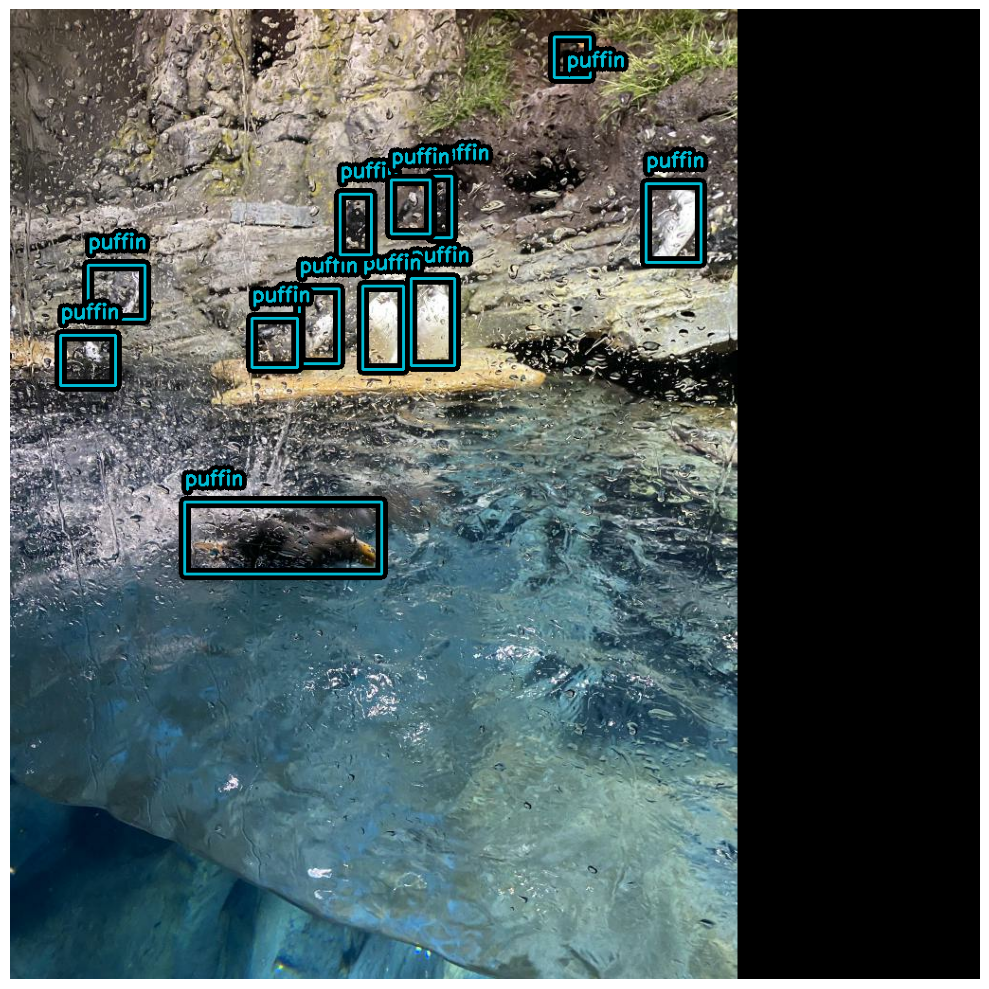

In [13]:
visualize_dataset(
    train_ds,
    value_range=(0, 255),
    rows=1,
    cols=1,
    bounding_box_format='center_xywh'
)

Load the data

In [14]:
# HYPERPARAMETERS

total_images = 449
EPOCHS = 10
BATCH_SIZE = 8
total_steps = (total_images // BATCH_SIZE) * EPOCHS

In [15]:
# Create train dataset
train_ds = load(split='train', bounding_box_format='center_xywh')
train_ds = train_ds.ragged_batch(BATCH_SIZE)

# Create val dataset
eval_ds = load(split='test', bounding_box_format='center_xywh')
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)

In [16]:
batch = next(iter(train_ds.take(1)))

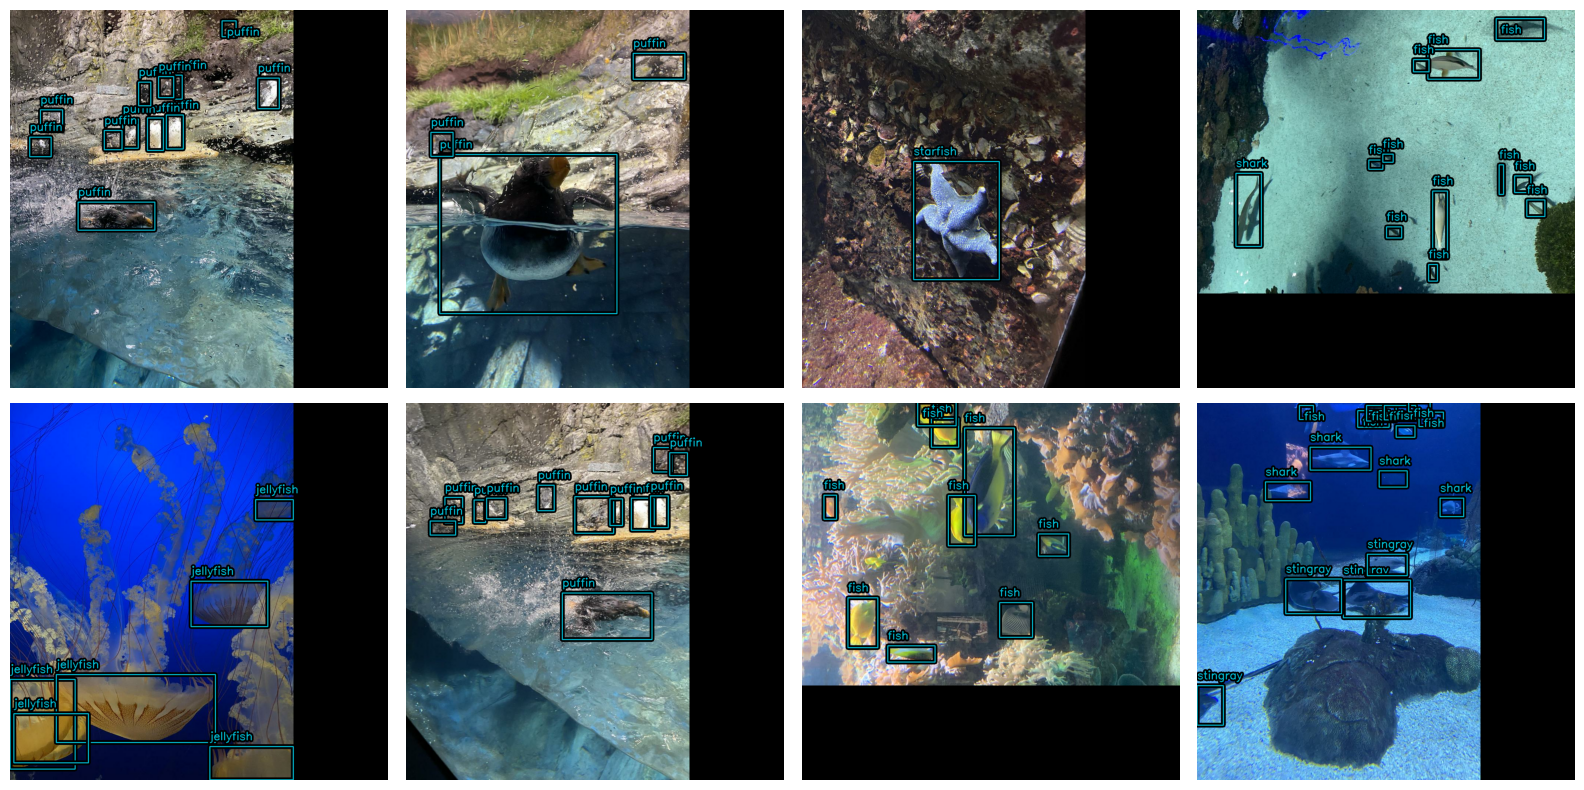

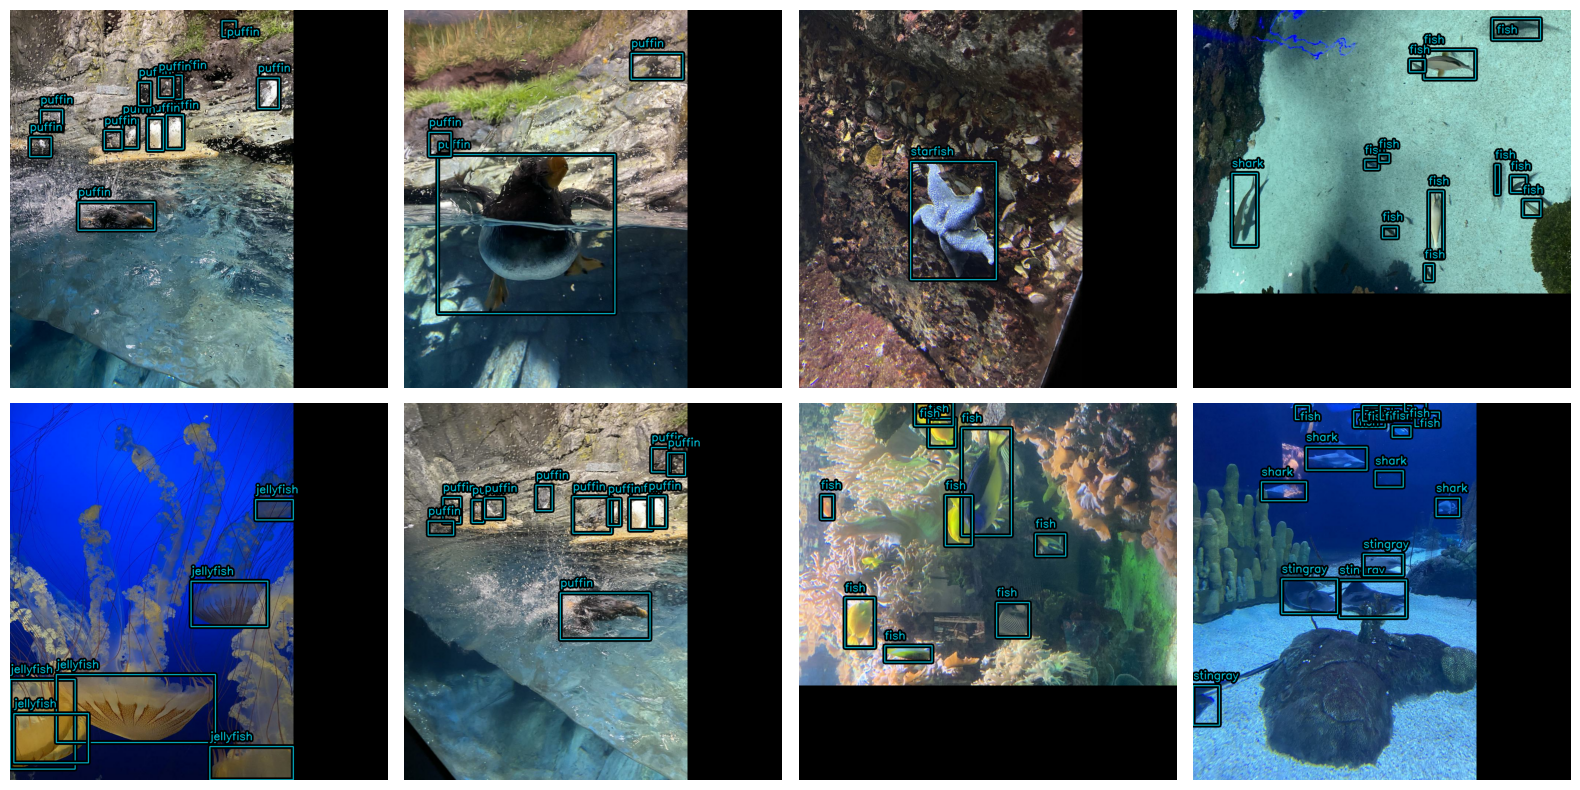

In [17]:
keras_cv.visualization.plot_bounding_box_gallery(
    batch['images'].to_tensor(),
    y_true=batch['bounding_boxes'],
    value_range=(0, 255),
    scale=4,
    rows=2,
    cols=4,
    class_mapping=class_mapping,
    bounding_box_format='center_xywh'
)

Augmentation pipeline

In [18]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="center_xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="center_xywh"
        ),
    ]
)

In [19]:
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

Eval pipeline

In [20]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="center_xywh"
)

In [21]:
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

Model construction

In [23]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="center_xywh",
)

Optimizer

In [24]:
optimizer = optimizers.SGD(
    decay=5e-4,
    momentum=0.9,
    global_clipnorm=10.
)

c:\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model compilation

In [38]:
model.compile(
    optimizer=optimizer,
    classification_loss="focal",
    box_loss="smoothl1",
)

Fit the model

In [26]:
history = model.fit(
  train_ds.take(1),
  validation_data=eval_ds.take(1),
  epochs=1
)

      1/Unknown 27s 27s/step - loss: 1.9300

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - loss: 1.9300 - val_loss: 1.8358


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def line_plot(
    data,
    title=None,
    legend="auto",
    xlabel=None,
    ylabel=None,
    show=None,
    path=None,
    transparent=True,
    dpi=60,
    palette="mako_r",
):

    if show and path is not None:
        raise ValueError("Expected either `show` or `path` to be set, but not both.")
    if path is None and show is None:
        show = True
    palette = sns.color_palette("mako_r", len(data.keys()))

    sns.lineplot(data=data, palette=palette, legend=legend)
    plt.legend(list(data.keys()))

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.suptitle(title)
    plt.show()
    plt.close()

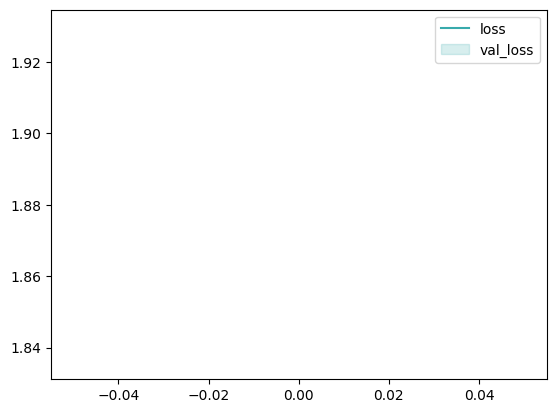

In [29]:
line_plot(data=history.history)

In [30]:
from keras_cv import bounding_box
from keras_cv import visualization

In [39]:
weights_path = keras.utils.get_file(origin='https://huggingface.co/Lukewood/aquarium-detector/resolve/main/marine-critter-detector.h5')
model.load_weights(weights_path)

141584608/141584608 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [42]:
model

<RetinaNet name=retina_net, built=True>

In [49]:
def visualize_detections(model, dataset):
    images, y_true = next(iter(dataset))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format='center_xywh',
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [51]:
y_pred = model.predict(total_images)

ValueError: Unrecognized data type: x=449 (of type <class 'int'>)

In [50]:
visualize_detections(model, train_ds)

ValueError: Unrecognized data type: x=images (of type <class 'str'>)

In [46]:
sharks = tf.keras.utils.get_file(origin="https://media.istockphoto.com/id/1004792742/photo/megalodon-scene-3d-illustration.jpg?s=612x612&w=0&k=20&c=32FRpoHx1Ff1o1FU2OPr1twOftSeuYhTpofqz_DSPK8=")
sharks = keras.utils.load_img(sharks)
sharks = np.array(sharks)

23639/23639 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


In [47]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="center_xywh"
)
image_batch = inference_resizing([sharks])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


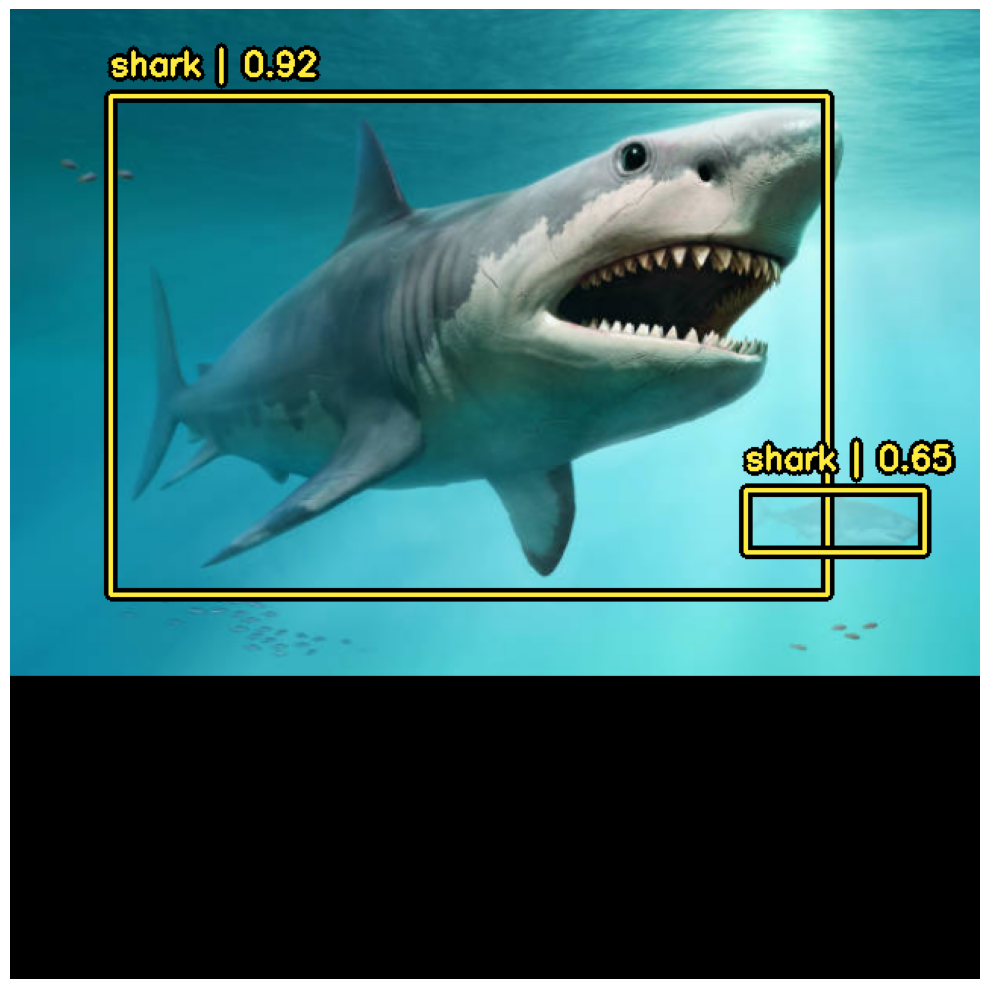

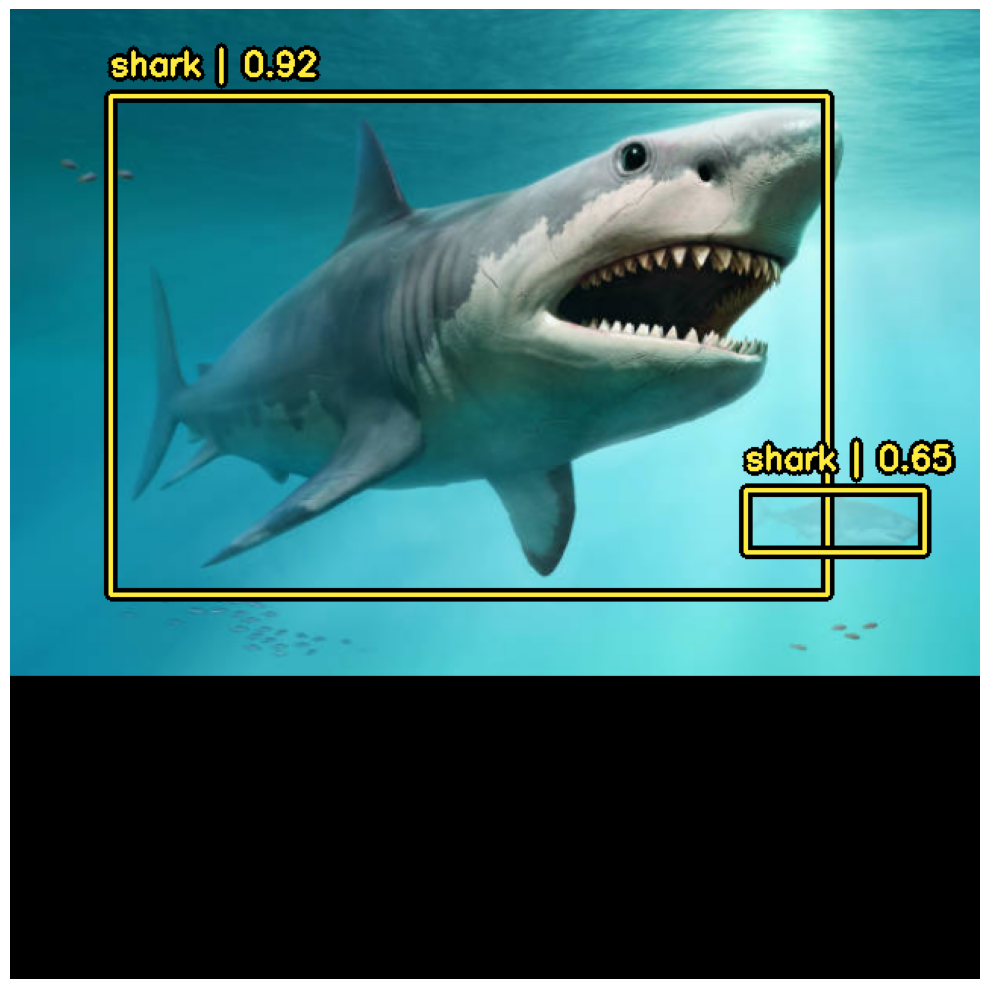

In [48]:
y_pred = model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=10,
    font_scale=0.7,
    bounding_box_format="center_xywh",
    class_mapping=class_mapping,
)